In [1]:
import numpy as np
from EmbedSeg.utils.create_dicts import create_test_configs_dict
from EmbedSeg.test import begin_evaluating
from glob import glob
import tifffile
import matplotlib.pyplot as plt
from EmbedSeg.utils.visualize import visualize
from EmbedSeg.train import invert_one_hot
import os
from matplotlib.colors import ListedColormap
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import json
import torch

### Specify the path to the evaluation images

In [2]:
data_dir = '../../../data'
project_name = 'bbbc010-2012'
print("Evaluation images shall be read from: {}".format(os.path.join(data_dir, project_name)))

Evaluation images shall be read from: ../../../data/bbbc010-2012


### Specify evaluation parameters 

Some hints:
* `tta`: Setting this to True (default) would enable **test-time augmentation**
* `ap_val`: This parameter ("average precision value") comes into action if ground truth segmentations exist for evaluation images, and allows to compare how good our predictions are versus the available ground truth segmentations.
* `checkpoint_path`: This parameter provides the path to the trained model weights which you would like to use for evaluation. One could test the pretrained model (available at `'../../../pretrained_models/bbbc010-2012/best_iou_model.pth'`) to get a quick glimpse on the results.
* `save_dir`: This parameter specifies the path to the prediction instances. Equal to `inference` by default.
* `save_images`: If True, this saves predictions at `./inference/predictions/` 
* `save_results`: If True, this saves results at `./inference/results/`

In the cell after this one, a `test_configs` dictionary is generated from the parameters specified here!
<a id='checkpoint'></a>

In [3]:
# uncomment for the model trained by you
# checkpoint_path = os.path.join('experiment', project_name+'-'+'demo', 'best_iou_model.pth')
# if os.path.isfile('data_properties.json'): 
#     with open('data_properties.json') as json_file:
#         data = json.load(json_file)
#         one_hot, data_type, min_object_size, n_y, n_x, avg_bg = data['one_hot'], data['data_type'], int(data['min_object_size']), int(data['n_y']), int(data['n_x']), float(data['avg_background_intensity'])
# if os.path.isfile('normalization.json'): 
#     with open('normalization.json') as json_file:
#         data = json.load(json_file)
#         norm = data['norm']

# use the following for the pretrained model weights
torch.hub.download_url_to_file(url = 'https://owncloud.mpi-cbg.de/index.php/s/yTNnewbAEFx4qBJ/download', 
                               dst = 'pretrained_model', progress=True)
import zipfile
with zipfile.ZipFile('pretrained_model', 'r') as zip_ref:
    zip_ref.extractall('')
checkpoint_path = os.path.join(project_name+'-'+'demo', 'best_iou_model.pth')
if os.path.isfile(os.path.join(project_name+'-'+'demo','data_properties.json')): 
    with open(os.path.join(project_name+'-'+'demo', 'data_properties.json')) as json_file:
        data = json.load(json_file)
        one_hot, data_type, min_object_size, n_y, n_x, avg_bg = data['one_hot'], data['data_type'], \
        int(data['min_object_size']), int(data['n_y']), int(data['n_x']), float(data['avg_background_intensity'])
if os.path.isfile(os.path.join(project_name+'-'+'demo','normalization.json')): 
    with open(os.path.join(project_name+'-'+'demo', 'normalization.json')) as json_file:
        data = json.load(json_file)
        norm = data['norm']
        

0.00B [00:00, ?B/s]

In [4]:
tta = True
ap_val = 0.5
save_dir = './inference'
save_images = True
save_results = True

In [5]:
if os.path.exists(checkpoint_path):
    print("Trained model weights found at : {}".format(checkpoint_path))
else:
    print("Trained model weights were not found at the specified location!")

Trained model weights found at : bbbc010-2012-demo/best_iou_model.pth


### Create `test_configs` dictionary from the above-specified parameters

Setting **`cluster_fast=False`** would produce more cell detections but the inference process would take longer.

In [6]:
test_configs = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        tta = tta, 
                                        ap_val = ap_val,
                                        min_object_size = min_object_size, 
                                        save_images = save_images,
                                        save_results = save_results,
                                        save_dir = save_dir,
                                        norm = norm,
                                        data_type = data_type,
                                        one_hot = one_hot,
                                        n_y = n_y,
                                        n_x = n_x,
                                        cluster_fast=True)

`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from ../../../data/bbbc010-2012, 
 -- trained weights accessed from bbbc010-2012-demo/best_iou_model.pth, 
 -- output directory chosen as ./inference


### Begin Evaluating

Setting `verbose` to True shows you Average Precision at IOU threshold specified by `ap_val` above for each individual image. The higher this score is, the better the network has learnt to perform instance segmentation on these unseen images.

In [7]:
begin_evaluating(test_configs, verbose = False)

2-D `test` dataloader created! Accessing data from ../../../data/bbbc010-2012/test/
Number of images in `test` directory is 50
Number of instances in `test` directory is 50
Number of center images in `test` directory is 0
*************************
Creating Branched Erfnet with [4, 1] outputs


100%|███████████████████████████████████████████| 50/50 [00:28<00:00,  1.75it/s]

Mean Average Precision (AP_dsb) at IOU threshold = 0.5 at foreground threshold = 0.50000, is equal to 0.96565


{'fg_thresh': 0.5, 'AP_dsb_05': 0.9656464124111185}

<div class="alert alert-block alert-warning"> 
  Common causes for a low score/error is: <br>
    1. Accessing the model weights at the wrong location: simply editing the <b> checkpoint_path</b> would fix the issue.  <br>
    2. GPU is out of memory - ensure that you shutdown <i>02-train.ipynb</i> notebook
</div>

<div class="alert alert-block alert-info"> 
The complete set of runs for different partitions of the data is available <b><a href = "https://github.com/juglab/EmbedSeg/wiki/BBBC010_2012"> here </a></b>!
</div>    

### Load a glasbey-style color map

In [8]:
new_cmp= np.load('../../../cmaps/cmap_60.npy')
new_cmp = ListedColormap(new_cmp)

### Investigate some qualitative results

Here you can investigate some quantitative predictions. GT segmentations and predictions, if they exist, are loaded from sub-directories under `save_dir`.
Simply change `index` in the next two cells, to show the prediction for a random index.
Going clockwise from top-left is 

    * the raw-image which needs to be segmented, 
    * the corresponding ground truth instance mask, 
    * the network predicted instance mask, and 
    * the confidence map predicted by the model

In [9]:
%matplotlib inline
if(save_images):
    prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
    ground_truth_file_names = sorted(glob(os.path.join(save_dir,'ground-truth','*.tif')))
    seed_file_names = sorted(glob(os.path.join(save_dir,'seeds','*.tif')))
    image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'test', 'images','*.tif')))

Image filename is B23.tif and index is 24


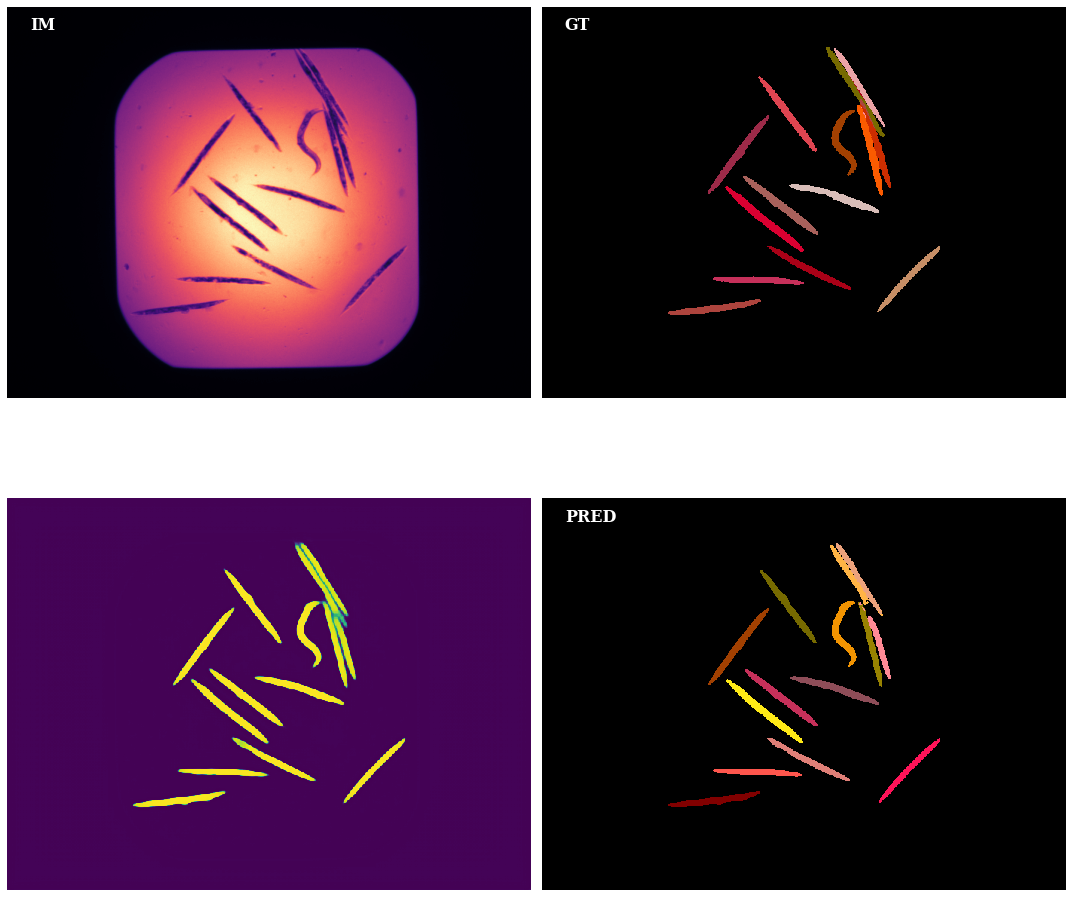

In [10]:
if(save_images):
    index = 24 
    print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
    prediction = tifffile.imread(prediction_file_names[index])
    image = tifffile.imread(image_file_names[index])
    seed = tifffile.imread(seed_file_names[index])
    if len(ground_truth_file_names) > 0:
        ground_truth = tifffile.imread(ground_truth_file_names[index])
        visualize(image = image, prediction = prediction, ground_truth = invert_one_hot(ground_truth), seed = seed, new_cmp = new_cmp)
    else:
        visualize(image = image, prediction = prediction, ground_truth = None, seed = seed, new_cmp = new_cmp)

Image filename is B21.tif and index is 23


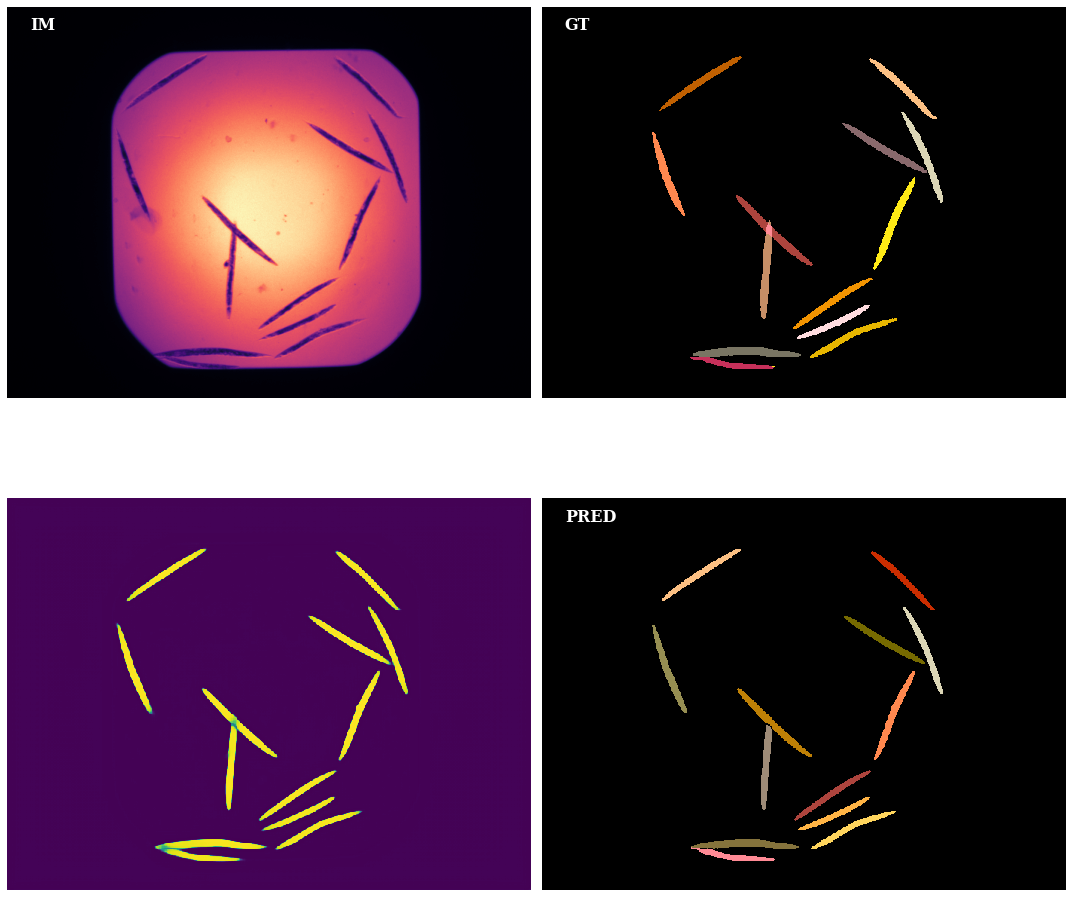

In [11]:
if (save_images):
    index = 23
    print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
    prediction = tifffile.imread(prediction_file_names[index])
    image = tifffile.imread(image_file_names[index])
    seed = tifffile.imread(seed_file_names[index])
    if len(ground_truth_file_names) > 0:
        ground_truth = tifffile.imread(ground_truth_file_names[index])
        visualize(image = image, prediction = prediction, ground_truth = invert_one_hot(ground_truth), seed = seed, new_cmp = new_cmp)
    else:
        visualize(image = image, prediction = prediction, ground_truth = None, seed = seed, new_cmp = new_cmp)
    